In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

In [2]:
def load_data(table="ice_cores"):
    """'table' should either be 'ice_cores' or 'stalagmites'."""
    
    if table == "ice_cores":
        df = pd.read_excel("data/d18O NGRIP 21.04.24.xlsx", skiprows=9, 
                           usecols=[2,3], dtype=float)
    elif table == "stalagmites":
        df = pd.read_excel("data/Borneo Stalagmite 02.04.25.xlsx", 
                           skiprows=9, usecols=[1,2], dtype=float)
    
    # set first year to 0 and choose years less than "N_YEARS"
    df.iloc[:,0] -= min(df.iloc[:,0])
    df = df[df.iloc[:,0] <= N_YEARS]
    
    # center data
    df.iloc[:,1] -= np.mean(df.iloc[:,1])

    return df.iloc[:,0].values, df.iloc[:,1].values

In [3]:
def extract_harmonics(t, y):
    residuals = y.copy()
    harmonics = []
    params = {
        "P": [], "dP": [], "A": [], "dA": [], "Phi": [], "dPhi": []
    }

    for i in range(MAX_HARMONICS):
        # feedback
        print_feedback(i)

        # compute periodogram of residuals
        P_guess = find_dominant_period(t, residuals)

        # fit harmonic
        fit_params, trace = fit_harmonic(t, residuals, P_guess)

        # build the harmonic with inferred params and subtract from residuals
        harmonic = build_model(t, fit_params[2], fit_params[0], fit_params[4])
        residuals -= harmonic

        # save current harmonic model and its params values
        harmonics.append(harmonic)
        for i,param_name in enumerate(["P", "A", "Phi"]):
            params[param_name].append(fit_params[2*i])
            params["d" + param_name].append(fit_params[2*i + 1])

    final_model = np.sum(harmonics, axis=0)
    params = pd.DataFrame(params)

    return final_model, params, residuals

In [4]:
def print_feedback(current_iteration):
    print(60 * "-")
    text = f" Iteration number {current_iteration+1} of {MAX_HARMONICS} "
    left_text = " " * ((60 - len(text))//2)
    right_text = " " * (60 - len(left_text))
    print(f"{left_text}{text}{right_text}")
    print(60 * "-")

In [5]:
def find_dominant_period(t, y):
    # uniform t and y for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)[1:]
    ck = np.fft.rfft(y_u)[1:]
    power = np.abs(ck) ** 2

    # find peaks above noise floor
    min_height = np.max(power) / NOISE_RATIO_THRESHOLD
    peaks, _ = find_peaks(power, height=min_height)
    if len(peaks) > 0:
        dominant_peak_ix = peaks[np.argmax(power[peaks])]
    else:
        dominant_peak_ix = 0

    # convert to period
    dominant_period = 1 / frequencies[dominant_peak_ix]

    # plot periodogram
    plt.figure(figsize=(12,4))

    periods = 1 / frequencies
    peak_periods = periods[peaks]
    peak_powers = power[peaks]

    plt.loglog(periods, power, 'b-', alpha=0.7, linewidth=0.8)
    plt.axhline(min_height, color='red', linestyle='--', label='Threshold')
    plt.scatter(peak_periods, peak_powers, color='red', s=50, zorder=5, 
                label=f'{len(peaks)} peaks found')
    
    plt.xlabel('Period')
    plt.ylabel('Power')
    plt.title("Periodogram")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return dominant_period

In [6]:
def fit_harmonic(t, y, period_guess):
    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.1*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu = mu, sigma = sig, observed = y)

        trace = pm.sample(N_SAMPLES, tune = N_TUNE, chains = N_CHAINS,
                          cores = min(4, N_CHAINS),
                          target_accept = 0.95,
                          return_inferencedata = True)
    params = []
    for param_name in ["P", "A", "phi"]:
        param_post = trace.posterior[param_name]
        
        # mean and std of current param
        params.append( param_post.mean().item() )
        params.append( param_post.mean().item() )

    return params, trace

In [7]:
def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

In [8]:
def show_results(t, y, model, residuals):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # plot proposed total fit
    axes[0].plot(t, y, 'k-', alpha=0.5, linewidth=0.5, label='Original Data')
    axes[0].plot(t, model, 'r-', linewidth=2, 
                label='Bayesian Fit')
    axes[0].set_title('Bayesian Harmonic Fit')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # plot proposed residuals
    axes[1].plot(t, residuals, 'b-', linewidth=0.8, alpha=0.7)
    res_std = np.std(residuals)
    axes[1].axhline(res_std, color='red', linestyle='--', alpha=0.7, 
                   label=f'±1σ = ±{res_std:.4f}')
    axes[1].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('Residuals')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Residual')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
# general settings
N_YEARS = 10000
MAX_HARMONICS = 10
NOISE_RATIO_THRESHOLD = 10
SAVE_PARAMS = False

# pymc settings
N_SAMPLES = 1000
N_TUNE = 1000
N_CHAINS = 4

------------------------------------------------------------
                  Iteration number 1 of 10                                            
------------------------------------------------------------


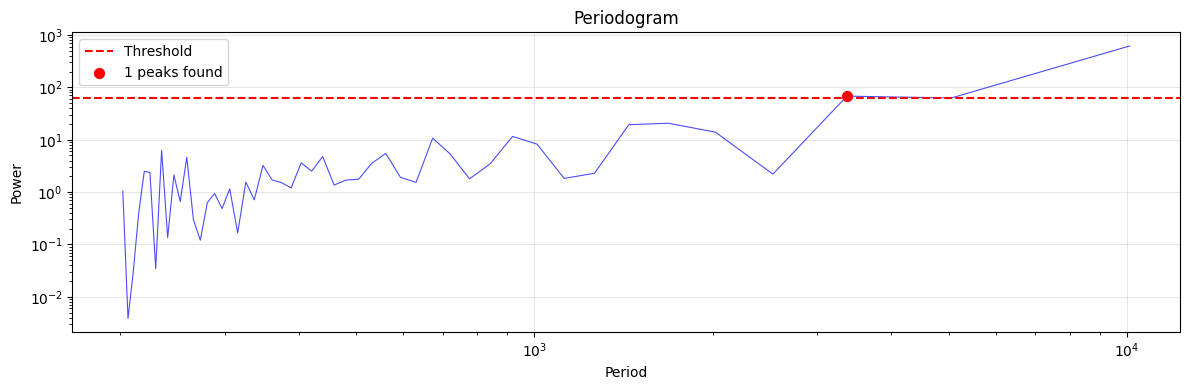

Initializing NUTS using jitter+adapt_diag...
/home/alberto/.local/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 2 of 10                                            
------------------------------------------------------------


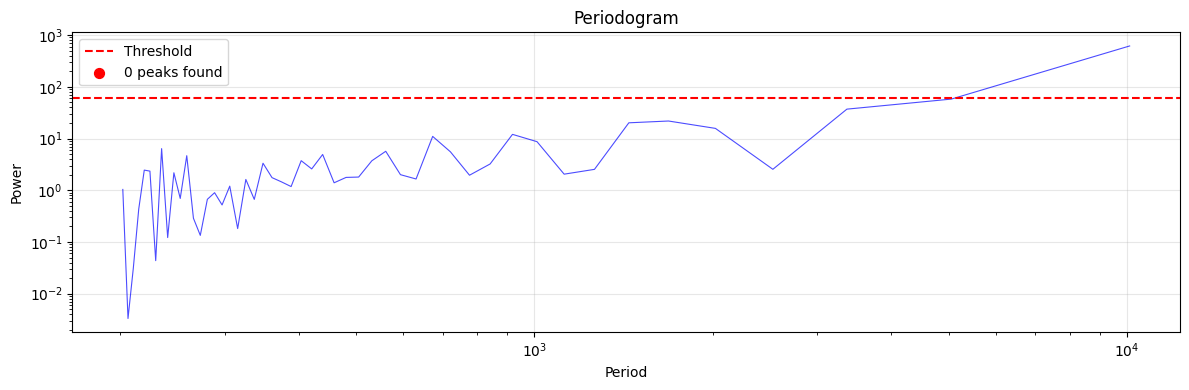

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [10]:
t, y = load_data("stalagmites")
model, params, residuals = extract_harmonics(t, y)

In [ ]:
show_results(t, y, model, residuals)